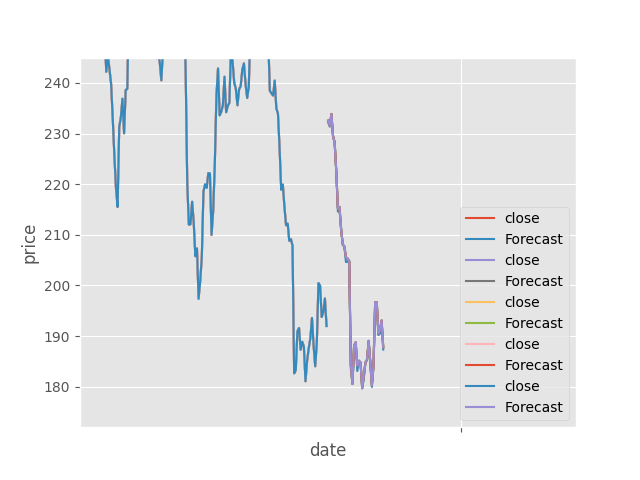

In [7]:
%matplotlib widget
import pandas as pd
import math, datetime, pickle
import numpy as np
from sklearn import preprocessing, model_selection
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

# Load the CSV file
df = pd.read_csv('tsla_split_adjusted.csv')
df.set_index('date', inplace=True)
df['date'] = pd.to_datetime(df.index, errors='coerce')  # Convert index to datetime


# Convert relevant columns to numeric
df['high'] = pd.to_numeric(df['high'], errors='coerce')
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df['open'] = pd.to_numeric(df['open'], errors='coerce')
df['volume'] = pd.to_numeric(df['volume'], errors='coerce')

# Drop rows with NaN values
df.dropna(inplace=True)

# Create new columns for HL_PCT and PCT_change
df['HL_PCT'] = (df['high'] - df['close']) / df['close'] * 100.0
df['PCT_change'] = (df['close'] - df['open']) / df['open'] * 100.0

# Select relevant columns
df = df[['close', 'HL_PCT', 'PCT_change', 'volume']]

forecast_col = 'close'

# Replace NaN values with -99999
df.fillna(-99999, inplace=True)

# Define forecast out
forecast_out = int(math.ceil(0.01 * len(df)))

# Shift 'label' column by forecast_out
df['label'] = df[forecast_col].shift(-forecast_out)

# Drop rows with NaN values after the shift
df.dropna(inplace=True)

# Separate features (X) and labels (y)
X = np.array(df.drop(['label'], axis=1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]


y = np.array(df['label'])
'''
# Train/test split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)

with open('linearregression.pickle','wb') as file:
    pickle.dump(clf,file)
'''  


pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)


accuracy = clf.score(X_test, y_test)
forecast_set = clf.predict(X_lately)


# Add predictions to DataFrame
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = pd.to_datetime(last_date).timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
df['close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('date')
plt.ylabel('price')
plt.show()